## Load Necessary Libraries and py files 

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

In [2]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append("../utils")

from construct_model import *
from text_pre_processor import *
from Helper_Function_MachineLearning_Clustering import *

%aimport construct_model
%aimport text_pre_processor
%aimport Helper_Function_MachineLearning_Clustering

## Load Cleaned DataFrame and Split into feature and target 

In [3]:
posts_df = pd.read_pickle('../data/interum/text_target.pkl')
# convert into features and target
feature = posts_df['cleaned_text']
label = posts_df['target']

## We will focus on these models after trying many classifiers:

* LogisticRegression

* RandomForest

* MultinomialNB



## Logistic Regression 

In [4]:
# after paramater tuning logistic regression works best with slight tuning for tfidvector
tfidf_vect_lg = TfidfVectorizer(ngram_range=(
    1, 2), max_df=0.5, min_df=6, max_features=9000)
# hyperparamater from extensive model gridsearch/randomsearch
lg = LogisticRegression(C=2, penalty='l1', random_state=42)

In [5]:
# run model and get results for logistic regression
lg_model = ConstructModel([tfidf_vect_lg, lg], feature, label)

In [6]:
# best estimator
lg_estimator = lg_model.pipe[1]
# final predictions (takes a while)
lg_pred = lg_model._X_test.apply(lg_model.get_prediction).apply(lambda x: x[0])

In [9]:
# check model accuracy score for test and train
lg_model.get_score()

Train Score:	 0.8931149705045172
Test Score:	 0.8150470219435737


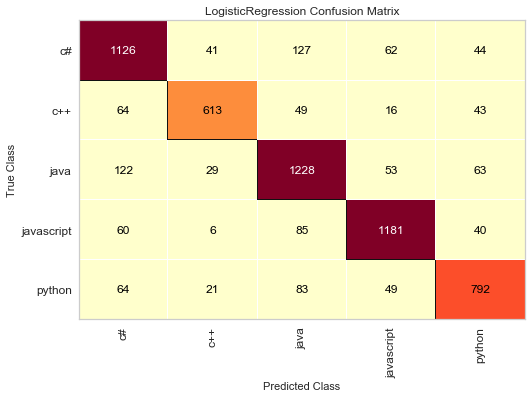

In [10]:
# confusion matrix
lg_model.get_confusion_matrix()

## RandomForest 

In [8]:
# after paramater tuning, a default settings works best
tfidf_vect_rf = TfidfVectorizer()
# hyperparamater from extensive model gridsearch/randomsearch
rf = RandomForestClassifier(
    criterion='gini', max_depth=1500, max_leaf_nodes=1000,
    min_samples_leaf=2, min_samples_split=2, n_estimators=1000, random_state=42)

In [12]:
# run model and get results for random forest
rf_model = ConstructModel([tfidf_vect_rf, rf], feature, label)

In [11]:
# final model
rf_estimator = rf_model.pipe[1]
# final predictions (takes a while)
rf_pred = rf_model._X_test.apply(rf_model.get_prediction).apply(lambda x: x[0])

In [16]:
# check model accuracy score for test and train
rf_model.get_score()

Train Score:	 0.907553318757477
Test Score:	 0.8015179013364131


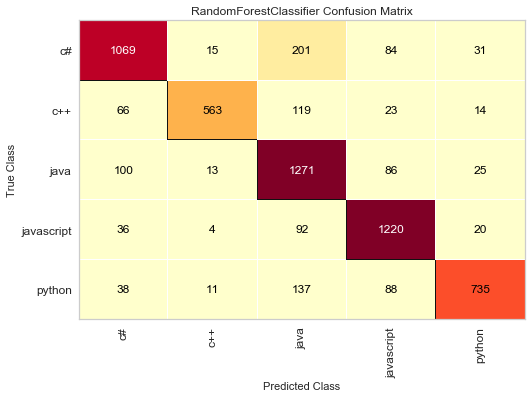

In [17]:
# check confusion matrix
rf_model.get_confusion_matrix()

## multinominalNB 

In [12]:
# after paramater tuning, a default settings works best
tfidf_vect_nb = TfidfVectorizer()
# hyperparamater from extensive model gridsearch/randomsearch
nb = MultinomialNB(alpha=0.1, fit_prior=False)

In [13]:
# run model and get results for nb
nb_model = ConstructModel([tfidf_vect_nb, nb], feature, label)

In [14]:
nb_estimator = nb_model.pipe[1]
# final predictions
nb_pred = nb_model._X_test.apply(nb_model.get_prediction).apply(lambda x: x[0])

In [23]:
# check model accuracy score for test and train 
nb_model.get_score()

Train Score:	 0.9083783672290747
Test Score:	 0.8130671506352087


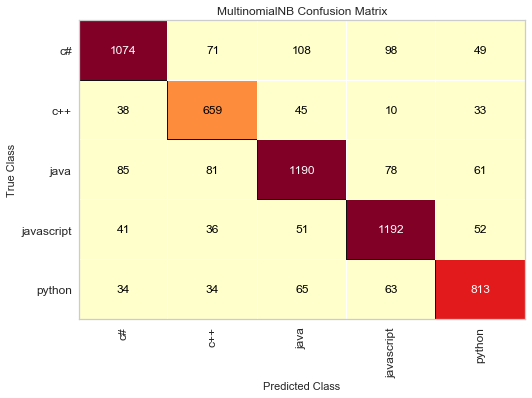

In [24]:
# check confusion matrix
nb_model.get_confusion_matrix()

### Combine 3 models  

  - Based upon the confusion matrix results, certain models do a better job predict certain label 
  
  - Combine and get majority vote as final results 

In [16]:
combined_pred = majority_vote(lg_pred, rf_pred, nb_pred)

In [17]:
accuracy_score(lg_model._y_test, combined_pred)

0.8313809602375846

In [18]:
# true test Y and class labels are the same for all models 
confusion_matrix_df(lg_model,lg_estimator,combined_pred)

,c# Pred,c++ Pred,java Pred,javascript Pred,python Pred
c# True,1123,39,129,74,35
c++ True,58,625,61,14,27
java True,88,27,1271,64,45
javascript True,37,12,75,1214,34
python True,43,13,87,60,806


## Most important features for all 3 models 

In [39]:
lg_coef_f = coef_features(lg_model.pipe)
nb_coef_f = coef_features(nb_model.pipe,lg=False)

In [40]:
lg_f = top_10_feature(lg_coef_f)
lg_f

,c#_lg,c++_lg,java_lg,javascript_lg,python_lg
0,writeline,boost,jvm,jquery,django
1,net,cout,jdk,backbone,numpy
2,dispose,std,jsp,console log,py
3,resharper,qt,system println,angularjs,def
4,window form,cpp,println,prototype,pythonic
5,linq,stl,spring,ecmascript,pep
6,msdn,gcc,jar,alert,matplotlib
7,ienumerable,int main,junit,browser,urllib
8,xaml,header file,hibernate,jslint,sqlalchemy
9,wpf,std string,jdbc,angular,typeerror


In [41]:
nb_f = top_10_feature(nb_coef_f,lg=False)
nb_f

,c#_nb,c++_nb,java_nb,javascript_nb,python_nb
0,string,std,string,function,list
1,use,int,class,jquery,file
2,public,use,use,use,use
3,class,const,file,var,print
4,net,function,method,div,py
5,get,class,public,page,like
6,method,code,new,like,way
7,new,vector,get,html,self
8,code,foo,like,script,get
9,list,string,way,way,line


In [42]:
importance_score_rf = rf_estimator.feature_importances_
feature_name_rf = rf_model.pipe[0].get_feature_names()
importance_f_rf =[]
for c, f in zip(importance_score_rf,feature_name_rf):
    if c:
        importance_f_rf.append((f,c))
top_10 = sorted(importance_f_rf, key=lambda x: x[1], reverse = True)[:10]

Text(0.5, 1.0, 'Random Forest Top 10 most Important Key Word Features')

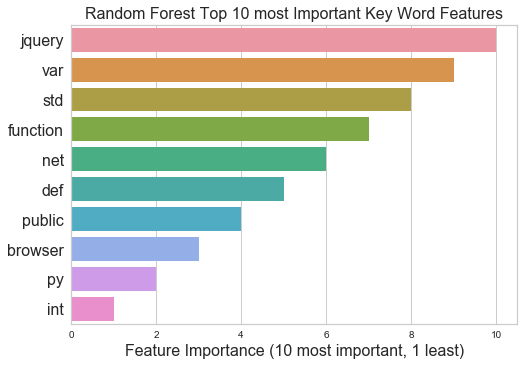

In [43]:
sns.barplot(x= np.arange(10,0,-1), y = [f[0] for f in top_10])
plt.xlabel('Feature Importance (10 most important, 1 least)', size = 16)
plt.yticks(size=16)
plt.title('Random Forest Top 10 most Important Key Word Features', size = 16)